#

In [1]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import torch_input_edges, torch_input_edges, get_X_y, compute_edge_weights, get_X_y_acc
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from DL_utils import *

In [2]:
#Example use

# after executing preprocessing_utils.py with 4Students_AnXplore03 in the same directory
# a folder named "data_cleaned" will be created with the preprocessed mesh files
# the function get_X_y can be used to get the input and output data of mesh_id

#retrieve the list of all the mesh_ids
CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]
print(mesh_ids)
mesh_id = mesh_ids[0]

X_nodes, X_edges, y = get_X_y_acc(mesh_id, time_step=1)
print("X_nodes.shape", X_nodes.shape)
# print(X_nodes[0])
# print(X_edges.shape)
# print(X_edges)
# print(X_edges[0].shape)
# print(X_edges[1].shape)
# print(y.shape)

['137', '19', '25', '31', '42-3', '196-2', '42-2', '136', '120', '134', '26', '196-1', '42-1', '6', '135', '121', '23', '2', '3', '1', '34', '140', '197', '183', '168-2', '155', '157', '180', '194', '209', '208', '44', '195', '181', '168-1', '142', '152', '40', '185', '191', '219', '193-2', '55', '153', '151', '192', '193-1', '187', '178', '175', '161', '203', '217', '144-2', '202', '186-1', '148', '174', '162', '189', '214', '200', '9-1', '215', '188', '186-2', '177', '173', '54-1', '211', '205', '182-2', '182-3', '204', '210', '199', '172', '166', '158', '170', '164', '54-2', '206', '212', '182-1', '213', '207', '165', '171', '159', '163-2', '119-1', '11', '117', '163-1', '129', '119-2', '128', '138', '198-2', '139', '198-1', '28']
torch.Size([80, 12567, 7])
X_nodes.shape torch.Size([12567, 11])


In [3]:
data = torch.load(data_path / f"mesh_{mesh_id}.pth")
print(data.keys())
print(data['nodes'].shape)
print(data['nodes'][:,:,3:6].shape)
X_nodes_all, X_edges = data["nodes"], data["edges"]

dict_keys(['nodes', 'edges'])
torch.Size([80, 12567, 7])
torch.Size([80, 12567, 3])


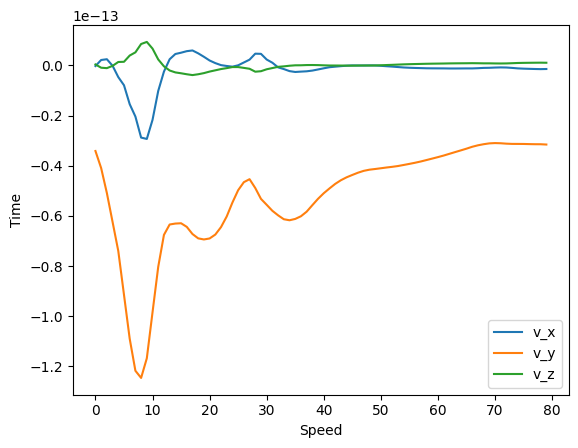

In [4]:
#speeds at node 100 across all time steps
plt.plot(X_nodes_all[:, 100, 3], label="v_x")
plt.plot(X_nodes_all[:, 100, 4], label="v_y")
plt.plot(X_nodes_all[:, 100, 5], label="v_z")
plt.xlabel("Speed")
plt.ylabel("Time")
plt.legend();

In [5]:
print(X_nodes_all.shape)
X_nodes_init = X_nodes_all[0]
# print(X_nodes_all[0,:,:])
velocities = torch.norm(X_nodes_init[:,3:6], p=2, dim=1)
print(velocities.shape)
border = torch.where(velocities < 1e-10)[0]
print(border)
# print(border[4500:4600])
print(border.shape)


torch.Size([80, 12567, 7])
torch.Size([12567])
tensor([   0,    1,    2,  ..., 4887, 4888, 4889])
torch.Size([4704])


In [6]:
class CFDGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CFDGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weights = None):
        x_0 = x[:,3:]
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weights) 
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.lin(x) 
        return  x

#I will use the mean squared error as loss function


#I will use the Adam optimize

In [7]:
def train_model(model, optimizer, mesh_ids, epochs=1000):
    loss_array = []
    for epoch in range(epochs):
        mesh_id = random.choice(mesh_ids)
        time_step = random.randint(0, 34)
        X_nodes, X_edges, y = get_X_y_acc(mesh_id, time_step=time_step)
        # print("X_nodes.shape", X_nodes.shape) 
        X_nodes = X_nodes[:,3:] # Remove the coordinates
        # print("X_nodes.shape", X_nodes.shape) 
        edge_weights = compute_edge_weights(X_edges, X_nodes)
        optimizer.zero_grad()
        out = model(X_nodes, X_edges, edge_weights)
        loss = F.mse_loss(out, y)
        loss.backward()
        optimizer.step()
        loss_array.append(loss.item())
        # print(f'Epoch {epoch}, Loss: {loss.item()}')
    return loss_array

# Train the model

def evaluate_model(model, mesh_ids):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for mesh_id in mesh_ids:
            for time_step in range(35):  # Assuming there are 35 time steps
                X_nodes, X_edges, y = get_X_y(mesh_id, time_step=time_step)
                X_nodes_input = X_nodes  # Remove the coordinates
                edge_weights = compute_edge_weights(X_edges, X_nodes_input)
                y_pred = model(X_nodes_input, X_edges, edge_weights)
                loss = F.mse_loss(y_pred, y)
                total_loss += loss.item()
    
    average_loss = total_loss / (len(mesh_ids) * 35)
    return average_loss

In [8]:
from DL_utils import train_test_sets

# Initialisation du modèle et de l'optimiseur
model = CFDGNN(in_channels=8, hidden_channels=16, out_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split des données en ensembles d'entraînement et de test
train_mesh_ids, test_mesh_ids = train_test_sets(mesh_ids, test_size=0.2, random_state=42)

# Entraînement du modèle
train_loss = train_model(model, optimizer, train_mesh_ids, epochs=20)

# Évaluation du modèle
average_loss = evaluate_model(model, test_mesh_ids)

print(f'Average Test Loss: {average_loss:.4f}')

torch.Size([80, 9682, 7])
torch.Size([80, 12067, 7])
torch.Size([80, 12792, 7])
torch.Size([80, 11465, 7])
torch.Size([80, 13429, 7])
torch.Size([80, 15603, 7])
torch.Size([80, 9949, 7])
torch.Size([80, 12253, 7])
torch.Size([80, 11669, 7])
torch.Size([80, 12253, 7])
torch.Size([80, 10640, 7])
torch.Size([80, 12704, 7])
torch.Size([80, 11383, 7])
torch.Size([80, 13413, 7])
torch.Size([80, 10439, 7])
torch.Size([80, 22921, 7])
torch.Size([80, 12313, 7])
torch.Size([80, 12567, 7])
torch.Size([80, 11295, 7])
torch.Size([80, 12325, 7])
Average Test Loss: 1140182.4015


Text(0, 0.5, 'Train loss')

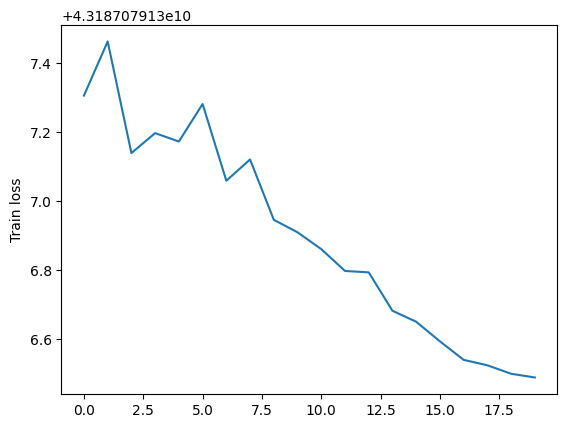

In [10]:
from scipy.ndimage import gaussian_filter1d
train_loss = gaussian_filter1d(train_loss, sigma=100)
plt.plot(train_loss)
plt.ylabel("Train loss")
